# How shall radiative heating be best diagnosed from CloudSat/Calipso 2B-FLXHR-LIDAR?

The purpose of this notebook is to settle on the "best" way to diagnose radiative heating from the radiative fluxes provided by 2B-FLXHR-LIDAR dataset. Best here means that the approach works equally well for all-sky and clear-sky radiative heating and for shortwave and longwave, and that the all-sky heating rates are in close agreement with the radiative heating QR provided also by 2B-FLXHR-LIDAR.

**Result: The preferred approach is to derive heating rates from the vertical flux difference divided by the pressure level thickness (approach 3). Approach 2 (based on density) gives the same result though.**

In [1]:
import rioxarray as rxr
import xarray as xr
import astropy
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Helper functions to read longitude, latitude and height.

Note, however, that plots with lat or lon as the x-axis do not work because lat and lon are not strictly increasing or deceasing as a function of the granule's orbit track.

In [2]:
def get_lon_lat(fname):
    """
    Get geographical position for hdf4 file.
    Adapted from https://gitlab.phaidra.org/climate/icon_2.3.0_ice-mp_rad_vis/-/blob/master/CloudSat/CloudSat_read.py

    Input:
    - fname: full path of hdf file (string)
    Output:
    - longitude: longitude in deg for each ray
    - latitude:  latitude in deg for each ray
    """
    import numpy as np
    from pyhdf import HDF, VS
    h  = HDF.HDF(fname)
    vs = h.vstart()
    # latitude
    latid = vs.attach(vs.find('Latitude'))
    latid.setfields('Latitude')
    nrecs, _, _, _, _ = latid.inquire()
    latitude = np.array(latid.read(nRec=nrecs)).squeeze()
    latid.detach()
    # longitude
    lonid = vs.attach(vs.find('Longitude'))
    lonid.setfields('Longitude')
    nrecs, _, _, _, _ = lonid.inquire()
    longitude = np.array(lonid.read(nRec=nrecs)).squeeze()
    lonid.detach()
    return longitude, latitude

In [3]:
def get_height(fname):
    """
    Get 2d height array for hdf4 file.

    Input:
    - fname: full path of hdf file (string)
    Output:
    - height: 2d numpy array with dimensions nray x levels
    """
    import numpy as np
    from pyhdf.SD import SD, SDC
    hdf = SD(fname, SDC.READ)
    height = hdf.select('Height')
    height = height[:,:]
    return height

## Read in the pair of 2B-FLXHR-LIDAR and ECMWF-AUX files for a single granule.

In [4]:
from pathlib import Path

granule="2006250192405_01929_CS_2B-FLXHR-LIDAR_GRANULE_P2_R05_E02_F00.hdf"

# file_cs is the Path object to the 2B-FLXHR-LIDAR file
# file_ec ist the Path object to the ECMWF-AUX file
for file_cs in Path("/jetfs/shared-data/CLOUDSAT/Data/2B-FLXHR-LIDAR.P2_R05/").rglob(granule):
    file_ec = Path(str(file_cs).replace("/2B-FLXHR-LIDAR.P2_R05/","/ECMWF-AUX.P1_R05/").replace("_CS_2B-FLXHR-LIDAR_GRANULE_P2_","_CS_ECMWF-AUX_GRANULE_P1_"))
    data_cs = rxr.open_rasterio(file_cs)
    data_ec = rxr.open_rasterio(file_ec)

Read in geographical position and height.

In [5]:
lon, lat = get_lon_lat(str(file_cs))
height = get_height(str(file_cs))

## Read in heating rate QR, radiative fluxes, pressure and temperature. Also, construct the net radiative fluxes from the up and downward fluxes.

Set missing values to false. Note that the missing value information given in the metadata via the attributes is not always correct, as is not the missing value information provided at https://www.cloudsat.cira.colostate.edu/data-products/2b-flxhr-lidar. I therefore decided to derive the missing value information myself by monitoring the minimum values of the variables, and assuming that these are the missing values.

In [6]:
# all-sky heating rate provided by 2B-FLXR-LIDAR
QR = data_cs[1]["QR"]
missval = QR.min().values
QR = 0.01*xr.where(QR==missval, np.nan, QR)

# all-sky fluxes
FD = data_cs[0]["FD"]
missval = FD.min().values
FD = 0.1*xr.where(FD==missval, np.nan, FD)
FU = data_cs[0]["FU"]
missval = FU.min().values
FU = 0.1*xr.where(FU==missval, np.nan, FU)
FN = FD - FU

# clear-sky fluxes
FD_NC = data_cs[0]["FD_NC"]
missval = FD_NC.min().values
FD_NC = 0.1*xr.where(FD_NC==missval, np.nan, FD_NC)
FU_NC = data_cs[0]["FU_NC"]
missval = FU_NC.min().values
FU_NC = 0.1*xr.where(FU_NC==missval, np.nan, FU_NC)
FN_NC = FD_NC - FU_NC

# pressure and temperature from ECMWF-AUX
P = data_ec["Pressure"].squeeze()
missval = P.min().values
P = xr.where(P==missval, np.nan, P)
T = data_ec["Temperature"].squeeze()
missval = T.min().values
T = xr.where(T==missval, np.nan, T)

# pressure thickness of levels --> difference between half level pressures, 
# the latter are calculated as the means of full level pressures
Phalf1 = 0.5*(P.shift(x=-1).values + P.shift(x=+0).values)
Phalf2 = 0.5*(P.shift(x=+0).values + P.shift(x=+1).values)
# Phalf1 and Phalf2 are the same arrays, but shifted vertically by one level
# dP can then be calculated as the absolte difference between the two
DP = np.abs(Phalf2-Phalf1)
# note: the same can be achieved as follows, and has the advantage to keep the xarray structure
DP = 0.5*(P.shift(x=-1) - P.shift(x=+1))

# air density, ignoring the effects of moisture
RHO = P/(287.0*T)

## Some plotting to make sure the data was read in and calculated correctly.

In [7]:
# height does vary by less than ~1m between geographical positions, so simply use the same height everywhere for plotting
# normalize from m to km
height1d = 0.001* np.mean(height,0)

In [8]:
# all-sky heating rates
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.contourf(QR[0].y, height1d, QR[0].transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky shortwave heating"); plt.ylabel("height / km")
plt.subplot(1,2,2)
plt.contourf(QR[1].y, height1d, QR[1].transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky longwave heating"); plt.ylabel("height / km")

Text(0, 0.5, 'height / km')

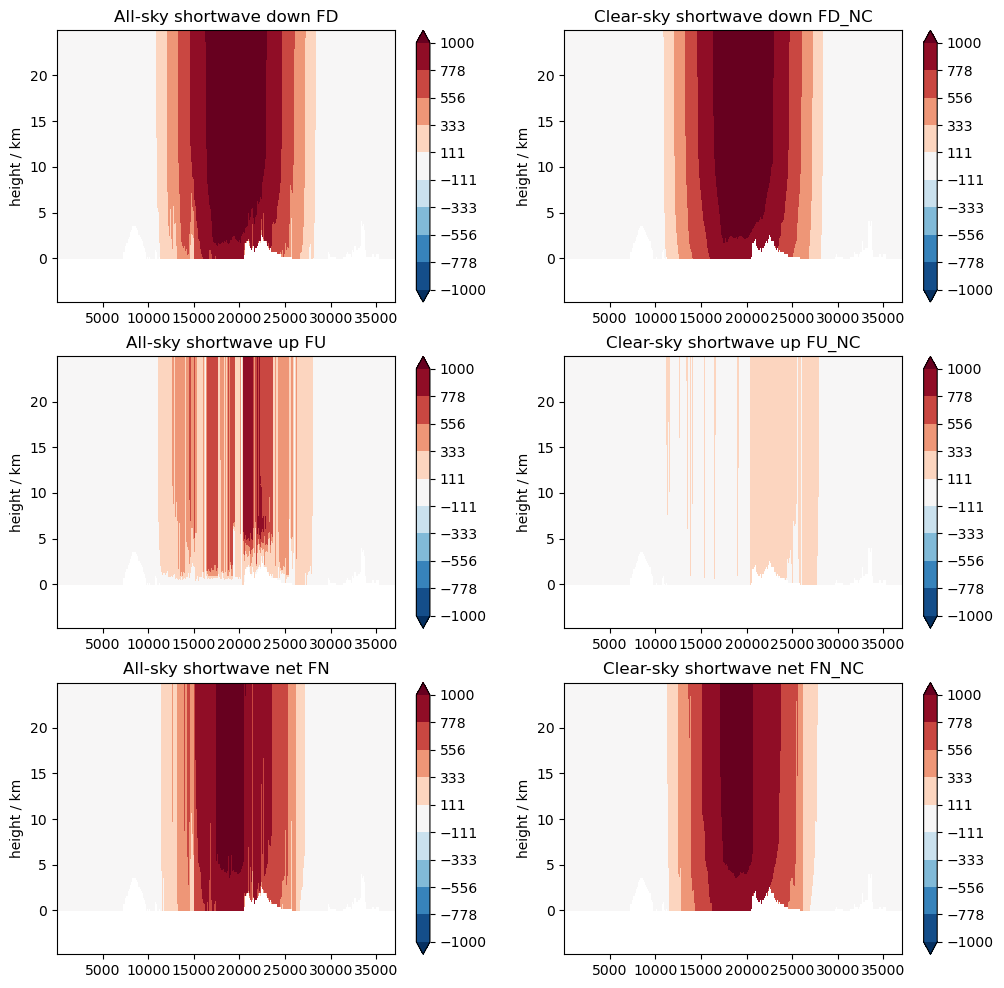

In [9]:
# shortwave fluxes
plt.figure(figsize=(12,12))

# all-sky
plt.subplot(3,2,1)
plt.contourf(FD[0].y, height1d, FD[0].transpose()[1:], extend="both", cmap="RdBu_r", levels=1000*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky shortwave down FD"); plt.ylabel("height / km");
plt.subplot(3,2,3)
plt.contourf(FU[0].y, height1d, FU[0].transpose()[1:], extend="both", cmap="RdBu_r", levels=1000*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky shortwave up FU"); plt.ylabel("height / km");
plt.subplot(3,2,5)
plt.contourf(FN[0].y, height1d, FN[0].transpose()[1:], extend="both", cmap="RdBu_r", levels=1000*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky shortwave net FN"); plt.ylabel("height / km");

# clear-sky
plt.subplot(3,2,2)
plt.contourf(FD_NC[0].y, height1d, FD_NC[0].transpose()[1:], extend="both", cmap="RdBu_r", levels=1000*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Clear-sky shortwave down FD_NC"); plt.ylabel("height / km");
plt.subplot(3,2,4)
plt.contourf(FU_NC[0].y, height1d, FU_NC[0].transpose()[1:], extend="both", cmap="RdBu_r", levels=1000*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Clear-sky shortwave up FU_NC"); plt.ylabel("height / km");
plt.subplot(3,2,6)
plt.contourf(FN_NC[0].y, height1d, FN_NC[0].transpose()[1:], extend="both", cmap="RdBu_r", levels=1000*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Clear-sky shortwave net FN_NC"); plt.ylabel("height / km");

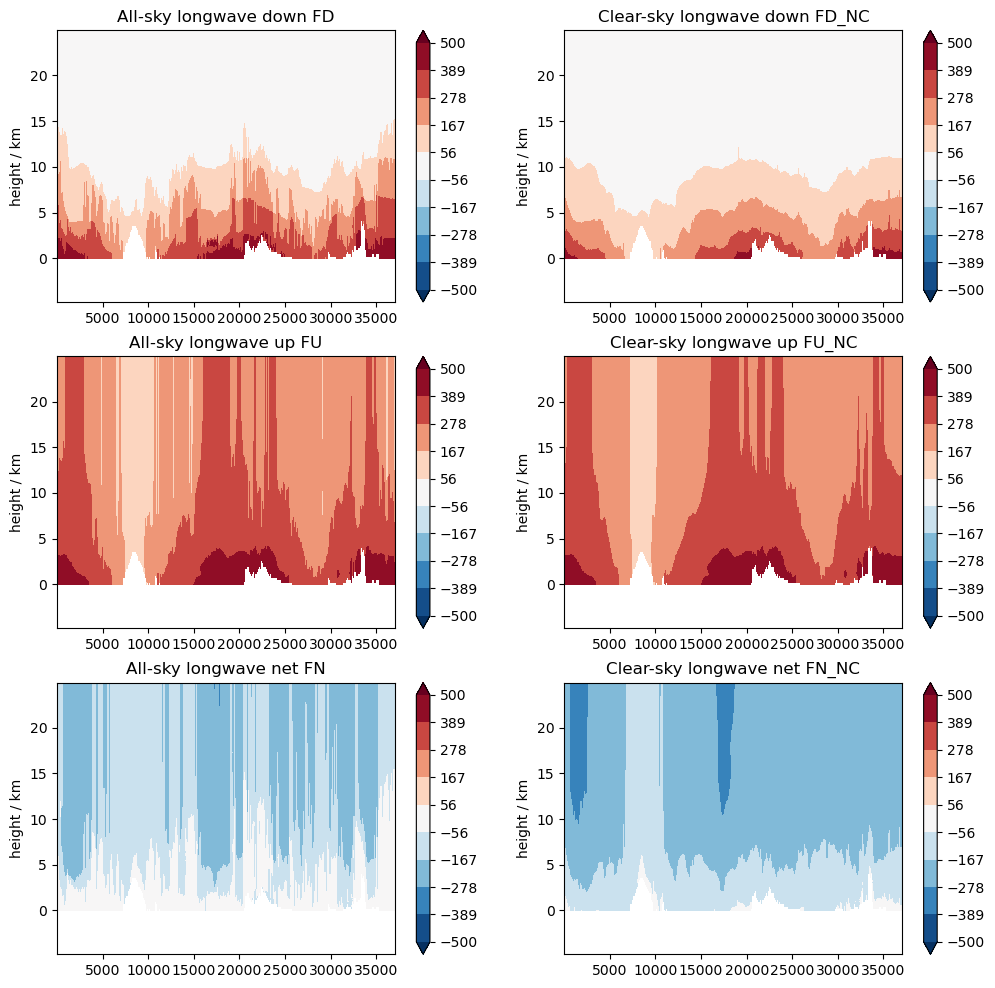

In [10]:
# longwave fluxes
plt.figure(figsize=(12,12))

# all-sky
plt.subplot(3,2,1)
plt.contourf(FD[1].y, height1d, FD[1].transpose()[1:], extend="both", cmap="RdBu_r", levels=500*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky longwave down FD"); plt.ylabel("height / km");
plt.subplot(3,2,3)
plt.contourf(FU[1].y, height1d, FU[1].transpose()[1:], extend="both", cmap="RdBu_r", levels=500*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky longwave up FU"); plt.ylabel("height / km");
plt.subplot(3,2,5)
plt.contourf(FN[1].y, height1d, FN[1].transpose()[1:], extend="both", cmap="RdBu_r", levels=500*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky longwave net FN"); plt.ylabel("height / km");

# clear-sky
plt.subplot(3,2,2)
plt.contourf(FD_NC[1].y, height1d, FD_NC[1].transpose()[1:], extend="both", cmap="RdBu_r", levels=500*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Clear-sky longwave down FD_NC"); plt.ylabel("height / km");
plt.subplot(3,2,4)
plt.contourf(FU_NC[1].y, height1d, FU_NC[1].transpose()[1:], extend="both", cmap="RdBu_r", levels=500*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Clear-sky longwave up FU_NC"); plt.ylabel("height / km");
plt.subplot(3,2,6)
plt.contourf(FN_NC[1].y, height1d, FN_NC[1].transpose()[1:], extend="both", cmap="RdBu_r", levels=500*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Clear-sky longwave net FN_NC"); plt.ylabel("height / km");

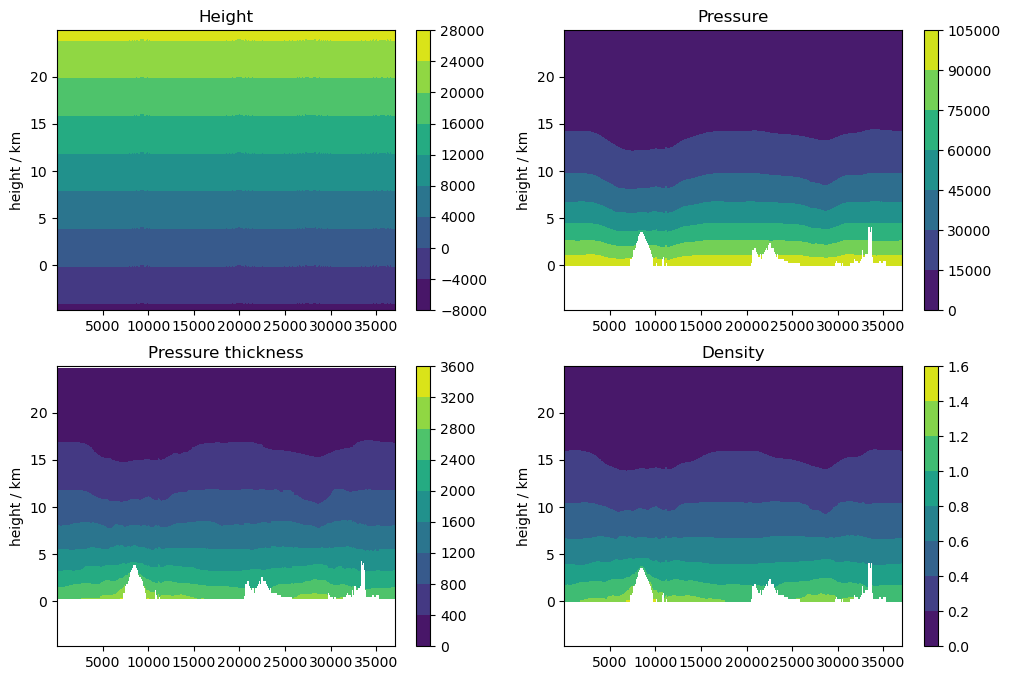

In [11]:
# height, pressure, pressure thickness and density
# longwave fluxes
plt.figure(figsize=(12,8))

# height
plt.subplot(2,2,1)
plt.contourf(P.y, height1d, height.transpose()); plt.colorbar()
plt.title("Height"); plt.ylabel("height / km");
# pressure
plt.subplot(2,2,2)
plt.contourf(P.y, height1d, P.transpose()); plt.colorbar()
plt.title("Pressure"); plt.ylabel("height / km");
# pressue thickness
plt.subplot(2,2,3)
plt.contourf(DP.y, height1d, DP.transpose()); plt.colorbar()
plt.title("Pressure thickness"); plt.ylabel("height / km");
# density
plt.subplot(2,2,4)
plt.contourf(RHO.y, height1d, RHO.transpose()); plt.colorbar()
plt.title("Density"); plt.ylabel("height / km");

## Test different approaches to derive radiative heating

### Aproach 1: use all-sky flux divergence and QR to derive "effective" scaling factor

The approach is based on the idea that $RH = \alpha dF/dp$, where $\alpha$ should be the same for all-sky and clear-sky and longwave and shortwave.

In [12]:
# derive alpha based on all-sky longwave
# use label="lower" so that x-coordinates are the same as for QR, i.e., run from 0.5 to 124.5
alpha = QR[1]/(FN[1].diff("x", label="lower"))

In [13]:
# if this approach works, it should allow us to recalculate the all-sky shortwave and longwave heating
QR_SW_dia1 = alpha*FN[0].diff("x", label="lower")
QR_LW_dia1 = alpha*FN[1].diff("x", label="lower")

But the comparison of the diagnosed all-sky shortwave heating with the actual heating shows that this approach is not feasible. I.e., see the diagnosed shortwave heating above 15 km. This is likely because for pixels with near zero flux longwave divergence, alpha becomes very large, and this can easily create (numerical) errors that are as large as the heating rate. 

One might avoid this by deriving alpha separately for shortwave and longwave, but the same problem might occur when using alpha derived from all-sky fluxes is applied to clear-sky fluxes.

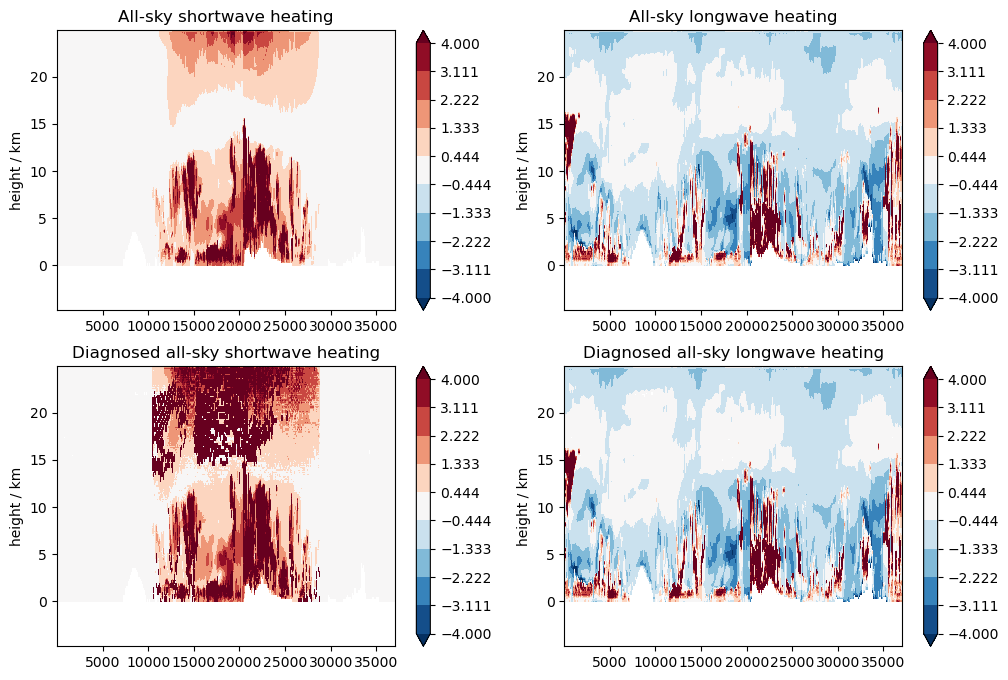

In [14]:
plt.figure(figsize=(12,8))

# actual heating
plt.subplot(2,2,1)
plt.contourf(QR[0].y, height1d, QR[0].transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky shortwave heating"); plt.ylabel("height / km");
plt.subplot(2,2,2)
plt.contourf(QR[1].y, height1d, QR[1].transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky longwave heating"); plt.ylabel("height / km");
# diagnosed heating
plt.subplot(2,2,3)
plt.contourf(QR[0].y, height1d, QR_SW_dia1.transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Diagnosed all-sky shortwave heating"); plt.ylabel("height / km");
plt.subplot(2,2,4)
plt.contourf(QR[0].y, height1d, QR_LW_dia1.transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Diagnosed all-sky longwave heating"); plt.ylabel("height / km");

### Aproach 1b: use all-sky flux divergence and QR to derive "effective" scaling factor separately for longwave and shortwave

This is the same as approach 1 except that $\alpha$ is defined separately for shortwav and longwave.

In [15]:
# derive alpha
# use label="lower" so that x-coordinates are the same as for QR, i.e., run from 0.5 to 124.5
alpha1b = QR/(FN.diff("x", label="lower"))

In [16]:
# if this approach works, it should allow us to recalculate the all-sky shortwave and longwave heating
QR_SW_dia1b = alpha1b[0]*FN[0].diff("x", label="lower")
QR_LW_dia1b = alpha1b[1]*FN[1].diff("x", label="lower")

The comparison of the diagnosed all-sky shortwave heating with the actual heating shows that this approach works for all-sky heating. This is expected and must be so by construction.

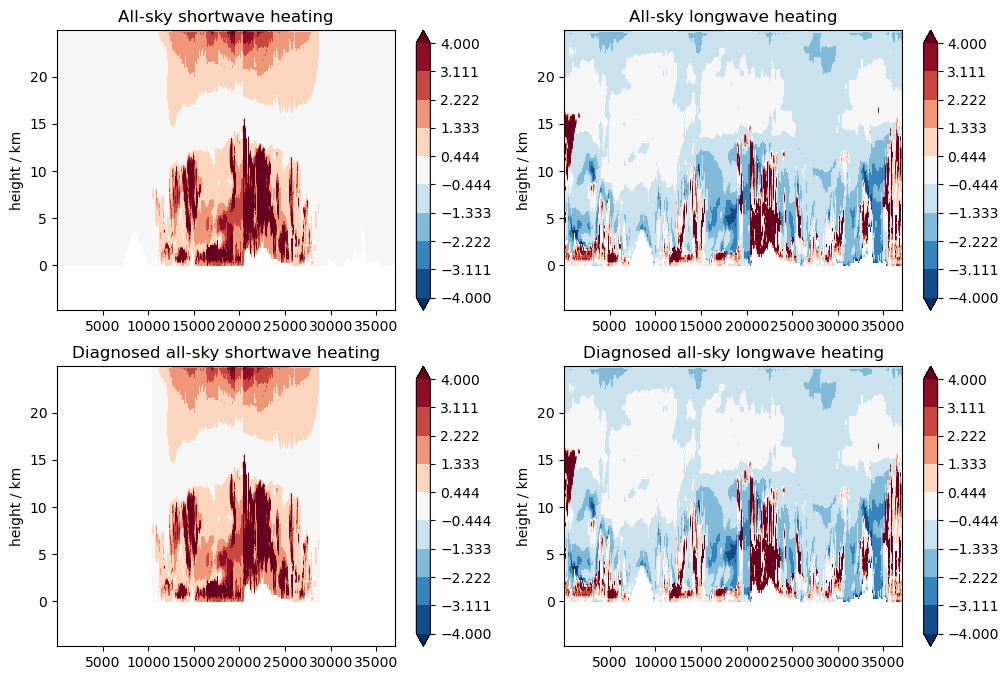

In [17]:
plt.figure(figsize=(12,8))

# actual heating
plt.subplot(2,2,1)
plt.contourf(QR[0].y, height1d, QR[0].transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky shortwave heating"); plt.ylabel("height / km");
plt.subplot(2,2,2)
plt.contourf(QR[1].y, height1d, QR[1].transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky longwave heating"); plt.ylabel("height / km");
# diagnosed heating
plt.subplot(2,2,3)
plt.contourf(QR[0].y, height1d, QR_SW_dia1b.transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Diagnosed all-sky shortwave heating"); plt.ylabel("height / km");
plt.subplot(2,2,4)
plt.contourf(QR[0].y, height1d, QR_LW_dia1b.transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Diagnosed all-sky longwave heating"); plt.ylabel("height / km");

A more stringent test is if the approach also allows us to derive clear-sky heating rates. But the plot below make it clear that clear-sky radiative heating cannot be diagnosed by this approach!

In [18]:
# if this approach works, it should allow us to calculate clear-sky shortwave and longwave heating
QR_SWcs_dia1b = alpha1b[0]*FN_NC[0].diff("x", label="lower")
QR_LWcs_dia1b = alpha1b[1]*FN_NC[1].diff("x", label="lower")

In [19]:
plt.figure(figsize=(12,4))

# diagnosed clear-sky heating
plt.subplot(1,2,1)
plt.contourf(QR[0].y, height1d, QR_SWcs_dia1b.transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Diagnosed clear-sky shortwave heating"); plt.ylabel("height / km");
plt.subplot(1,2,2)
plt.contourf(QR[0].y, height1d, QR_LWcs_dia1b.transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Diagnosed clear-sky longwave heating"); plt.ylabel("height / km");

### Approach 2: use density and height level difference 

The approach is based on the idea that $RH = 1/(cp*\rho) * dF/dz$. Level thickness is 240m.

In [20]:
cp = 1004;
dz = 240;
QR_SW_dia2 = -FN[0].diff("x", label="lower") / (cp*RHO*dz) * 86400  # units of K/day
QR_LW_dia2 = -FN[1].diff("x", label="lower") / (cp*RHO*dz) * 86400

The comparison with the actual heating rates shows that this works well below 15 km, but introduces noise above. Still, this is better than the alpha approach (approaches 1 and 1b).

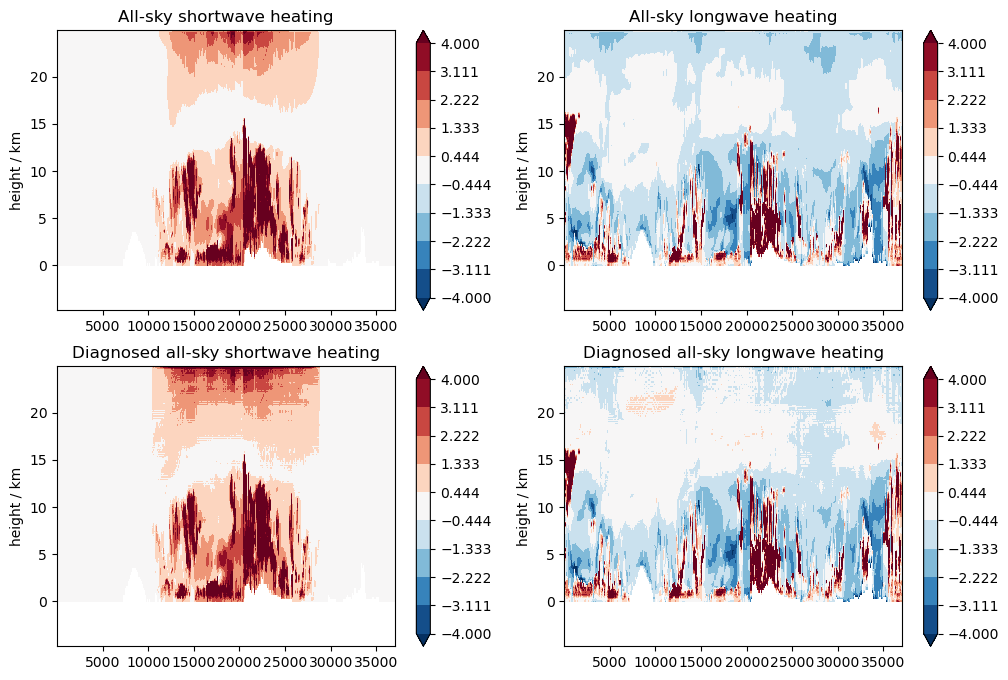

In [21]:
plt.figure(figsize=(12,8))

# actual heating
plt.subplot(2,2,1)
plt.contourf(QR[0].y, height1d, QR[0].transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky shortwave heating"); plt.ylabel("height / km");
plt.subplot(2,2,2)
plt.contourf(QR[1].y, height1d, QR[1].transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky longwave heating"); plt.ylabel("height / km");
# diagnosed heating
plt.subplot(2,2,3)
plt.contourf(QR[0].y, height1d, QR_SW_dia2.transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Diagnosed all-sky shortwave heating"); plt.ylabel("height / km");
plt.subplot(2,2,4)
plt.contourf(QR[0].y, height1d, QR_LW_dia2.transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Diagnosed all-sky longwave heating"); plt.ylabel("height / km");

### Aproach 3: use pressure level difference 

The approach is based on the idea that $RH = -g/cp * dF/dp$.

In [22]:
cp = 1004;
g = 9.81;
QR_SW_dia3 = -g * FN[0].diff("x", label="lower") / (cp*DP) * 86400  # units of K/day
QR_LW_dia3 = -g * FN[1].diff("x", label="lower") / (cp*DP) * 86400

Essentially the same result as for the density-z approach (approach 2). The noise persists above 15 km.

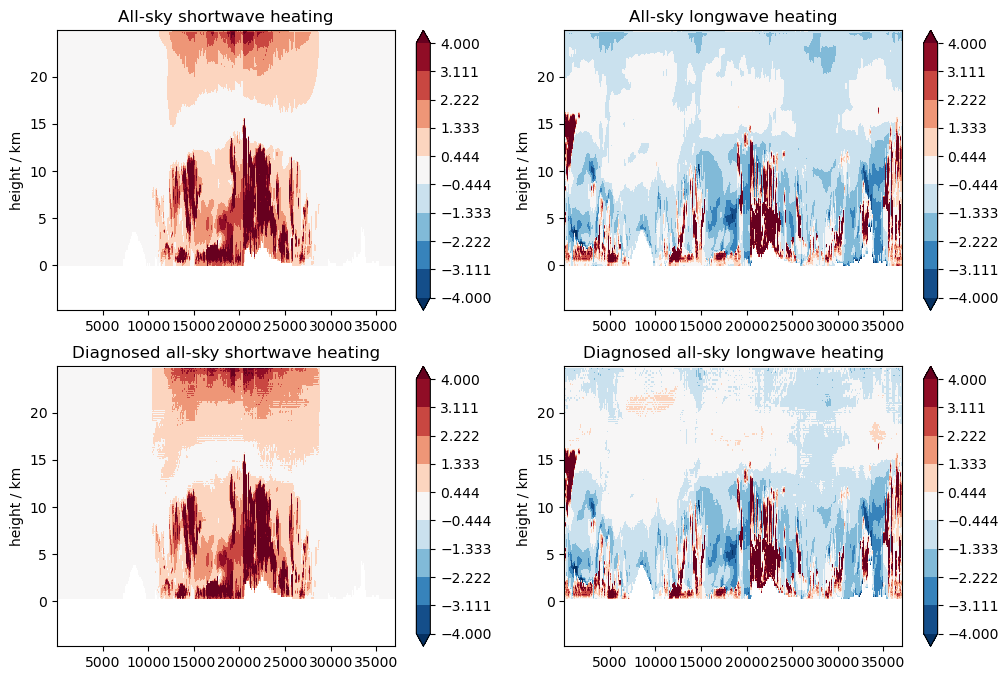

In [23]:
plt.figure(figsize=(12,8))

# actual heating
plt.subplot(2,2,1)
plt.contourf(QR[0].y, height1d, QR[0].transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky shortwave heating"); plt.ylabel("height / km");
plt.subplot(2,2,2)
plt.contourf(QR[1].y, height1d, QR[1].transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("All-sky longwave heating"); plt.ylabel("height / km");
# diagnosed heating
plt.subplot(2,2,3)
plt.contourf(QR[0].y, height1d, QR_SW_dia3.transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Diagnosed all-sky shortwave heating"); plt.ylabel("height / km");
plt.subplot(2,2,4)
plt.contourf(QR[0].y, height1d, QR_LW_dia3.transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Diagnosed all-sky longwave heating"); plt.ylabel("height / km");

So let us go with approach 3 and also test it for clear-sky heating.

In [24]:
QR_SWcs_dia3 = -g * FN_NC[0].diff("x", label="lower") / (cp*DP) * 86400  # units of K/day
QR_LWcs_dia3 = -g * FN_NC[1].diff("x", label="lower") / (cp*DP) * 86400

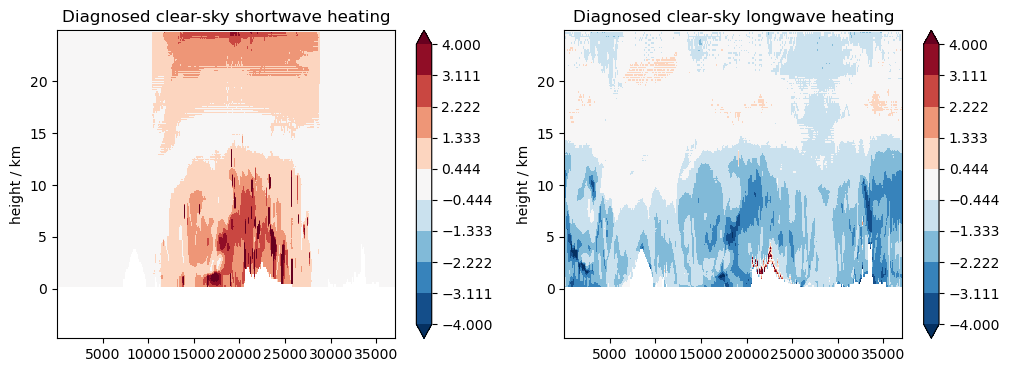

In [25]:
plt.figure(figsize=(12,4))

# diagnosed clear-sky heating
plt.subplot(1,2,1)
plt.contourf(QR[0].y, height1d, QR_SWcs_dia3.transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Diagnosed clear-sky shortwave heating"); plt.ylabel("height / km");
plt.subplot(1,2,2)
plt.contourf(QR[0].y, height1d, QR_LWcs_dia3.transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Diagnosed clear-sky longwave heating"); plt.ylabel("height / km");

This looks okay, apart from the noise above 15km. So let us go ahead and use approach three to derive cloud-radiative heating.

In [26]:
QR_SWCRH = -g * (FN[0]-FN_NC[0]).diff("x", label="lower") / (cp*DP) * 86400  # units of K/day
QR_LWCRH = -g * (FN[1]-FN_NC[1]).diff("x", label="lower") / (cp*DP) * 86400

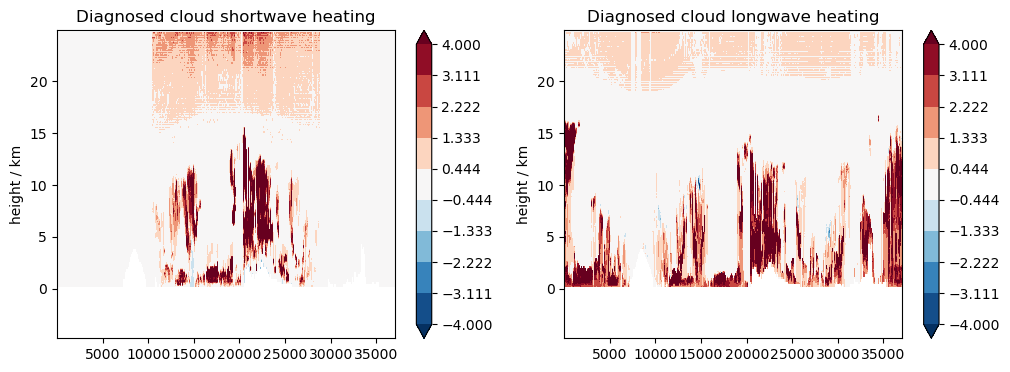

In [27]:
plt.figure(figsize=(12,4))

# diagnosed cloud-radiative heating
plt.subplot(1,2,1)
plt.contourf(QR[0].y, height1d, QR_SWCRH.transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Diagnosed cloud shortwave heating"); plt.ylabel("height / km");
plt.subplot(1,2,2)
plt.contourf(QR[0].y, height1d, QR_LWCRH.transpose(), extend="both", cmap="RdBu_r", levels=4*np.linspace(-1,1,10)); plt.colorbar()
plt.title("Diagnosed cloud longwave heating"); plt.ylabel("height / km");

For reference, we also plot the cloud optical depth to get a feeling for the underlying cloud field.

In [28]:
COD=data_cs[0]["COD"];
missval = COD.min().values
COD = 0.001*xr.where(COD==missval, np.nan, COD)

plt.figure(figsize=(6,4))
plt.subplot(1,1,1)
plt.contourf(COD.y, height1d, COD[1,:,1:].transpose(), extend="both", levels=2*np.linspace(0,1,10)); plt.colorbar()
plt.title("Longwave cloud optical depth"); plt.ylabel("height / km");